In [33]:
import os
from collections import namedtuple
import math
import json

import numpy as np
import pandas as pd
from skimage.feature import peak_local_max
from scipy.stats import multivariate_normal
from scipy.optimize import leastsq
import progressbar
import matplotlib.pyplot as plt
import imageio

from utoolbox.container import Volume

### Environment presets

In [2]:
file_path = os.path.join(
    *["data", "20170831_SIM", "SI_b1a2DSIM_os", "decWF", "RAWb1a2DSIM_os_ch0_stack0000_561nm.tif"]
)

In [3]:
dx = 50
dy = 50
dz = 300

In [4]:
kernel_size = 15
radius = (kernel_size-1) // 2

In [5]:
results = pd.DataFrame(
    columns=[
        'px', 'py', 'pz', # bounding box center
        'a',              # amplitude
        'cx', 'cy', 'cz', # center
        'wx', 'wy', 'wz', # sigma
    ]
)

### Load data

In [6]:
raw = Volume(file_path)
print("shape={}".format(raw.shape))
print("dtype={}".format(raw.dtype))

shape=(101, 1024, 1024)
dtype=uint16


In [7]:
print("mean={:.2f}, sd={:.2f}".format(np.mean(raw), np.std(raw)))

mean=53.87, sd=19.66


### Find peaks

In [8]:
th = np.mean(raw) + 2*np.std(raw)
coords = peak_local_max(
    raw, exclude_border=radius, min_distance=2*kernel_size, threshold_abs=th
)

In [9]:
print("{} peaks found".format(len(coords)))

163 peaks found


### Isolate the patches

In [10]:
patches = np.zeros((len(coords), kernel_size, kernel_size, kernel_size), dtype=np.float32)

In [11]:
index = 0
bar = progressbar.ProgressBar()
for coord in bar(coords):
    x = coord[2]
    y = coord[1]
    z = coord[0]
    
    results.loc[index, 'px'] = x
    results.loc[index, 'py'] = y
    results.loc[index, 'pz'] = z
    
    patches[index, ...] = raw[z-radius:z+radius+1, y-radius:y+radius+1, x-radius:x+radius+1]
    
    index += 1

100% (163 of 163) |#######################| Elapsed Time: 0:00:00 Time: 0:00:00


### Preview selected beads

In [13]:
raw_xy = np.amax(raw, axis=0)

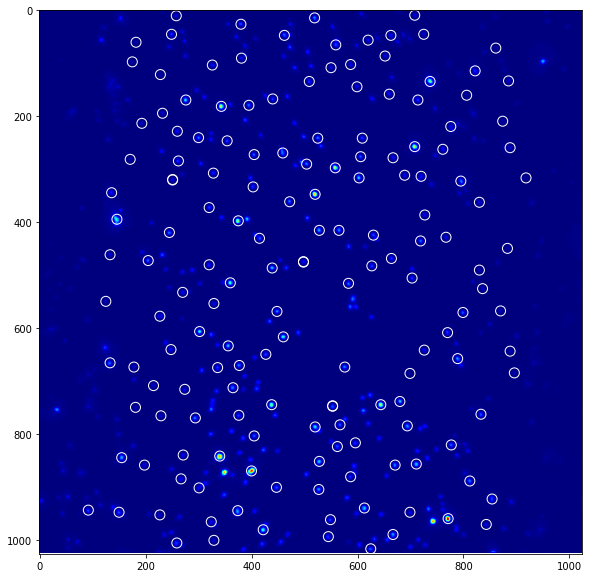

In [14]:
plt.figure(figsize=(10, 10))
plt.autoscale(enable=True, tight=True)

plt.imshow(raw_xy, cmap='jet')
plt.scatter(coords[:, 2], coords[:, 1], s=100, marker='o', facecolors='none', edgecolor='w')

### 3D fitting

In [15]:
Params = namedtuple('Params', 
    ['a',              # amplitude
     'cx', 'cy', 'cz', # centroid
     'wx', 'wy', 'wz'  # width
    ]
)

The fitting function.

In [16]:
def gaussian_3d(params):
    params = Params(*params)
    return lambda x, y, z: \
        params.a * np.exp(
            -( ((params.cx-x)/params.wx)**2 + 
               ((params.cy-y)/params.wz)**2 +
               ((params.cz-z)/params.wz)**2
             ) / 2
        )

In [17]:
def moments(data):
    s = data.sum()
    
    zi, yi, xi = np.indices(data.shape)
    cx = (xi*data).sum() / s
    cy = (yi*data).sum() / s
    cz = (zi*data).sum() / s
    
    t = data[int(cz), int(cy), :]
    wx = np.sqrt(np.abs((np.arange(t.size)-cx)**2 * t).sum() / t.sum())
    t = data[int(cz), :, int(cx)]
    wy = np.sqrt(np.abs((np.arange(t.size)-cy)**2 * t).sum() / t.sum())
    t = data[:, int(cy), int(cx)]
    wz = np.sqrt(np.abs((np.arange(t.size)-cz)**2 * t).sum() / t.sum())
    
    a = data.max()
    
    return Params(a, cx, cy, cz, wx, wy, wz)

In [18]:
def fit_gaussian_3d(data):
    """Returns fitting result of a 3D Gaussian distribution."""
    params = moments(data)
    err_func = lambda params: \
        np.ravel(gaussian_3d(params)(*np.indices(data.shape)) - data)
    optparams, success = leastsq(err_func, params)
    return Params(*optparams), success

In [19]:
index = 0
n_failed = 0
bar = progressbar.ProgressBar()
for patch in bar(patches):
    optparams, is_success = fit_gaussian_3d(patch)
    
    results.loc[index, 'a'] = optparams.a
    
    results.loc[index, 'cx'] = optparams.cx
    results.loc[index, 'cy'] = optparams.cy
    results.loc[index, 'cz'] = optparams.cz
    
    results.loc[index, 'wx'] = optparams.wx
    results.loc[index, 'wy'] = optparams.wy
    results.loc[index, 'wz'] = optparams.wz
    
    if not is_success:
        n_failed += 1
        
    index += 1

print("failed to fit {} beads".format(n_failed))

100% (163 of 163) |#######################| Elapsed Time: 0:00:03 Time: 0:00:03


failed to fit 0 beads


### Statistics

In [20]:
wx = results['wx'].mean()
wx_e = results['wx'].std()

wy = results['wy'].mean()
wy_e = results['wy'].std()

wz = results['wz'].mean()
wz_e = results['wz'].std()

$\text{FWHM} = 2 \sqrt{2 ln2} \sigma$

In [21]:
factor = 2 * math.sqrt(2 * math.log(2))

In [22]:
xres = wx * factor * dx
yres = wy * factor * dy
zres = wz * factor * dz

In [32]:
print("FWHM resolution (x, y, z) = ({:.4f}, {:.4f}, {:.4f}) nm".format(xres, yres, zres))

FWHM resolution (x, y, z) = (297.2797, 371.2456, 2970.0206) nm


### Save the result to files

Save cropped patches.

In [12]:
patches_folder = os.path.join(os.path.dirname(file_path), "patches")
if not os.path.exists(patches_folder):
    os.makedirs(patches_folder)
    
index = 0
bar = progressbar.ProgressBar()
for patch in bar(patches):
    patches_path = os.path.join(patches_folder, "{}.tif".format(index))
    imageio.volwrite(patches_path, patch)
    index += 1

100% (163 of 163) |#######################| Elapsed Time: 0:00:00 Time: 0:00:00


Save fitting results.

In [24]:
results_path = os.path.join(os.path.dirname(file_path), "fitting_results.csv")
results.to_csv(results_path, index=False)

Statistics summary.

In [39]:
summary_path = os.path.join(os.path.dirname(file_path), "summary.json")
with open(summary_path, 'w') as outfile:
    json.dump(
        {
            'source': os.path.basename(file_path),
            'unit': 'nm',
            'factor': factor,
            'spacing': {
                'x': dx,
                'y': dy, 
                'z': dz
            },
            'resolution': {
                'x': xres,
                'y': yres,
                'z': zres
            }
        }, 
        outfile, 
        indent=4, 
    )

### Fitting test

In [25]:
i_patch = 40
data = patches[i_patch, ...]

optparams, success = fit_gaussian_3d(data)
print("success? {}".format(success))

Params(*optparams)

success? 1


Params(a=2136.4639128477197, cx=7.298463859999113, cy=7.022347677444064, cz=7.186137072024189, wx=1.6629775999717875, wy=2.8742341260558044, wz=3.1895208745660213)

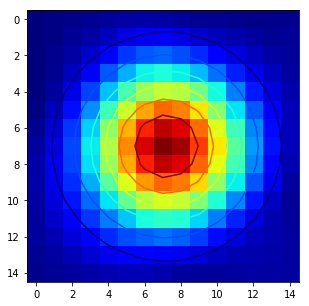

In [26]:
plt.figure(figsize=(5, 5))
plt.autoscale(enable=True, tight=True)

data_fit = gaussian_3d(optparams)(*np.indices(data.shape))
plt.imshow(np.amax(data, axis=0), cmap='jet')
plt.contour(np.amax(data_fit, axis=0), cmap='jet')

In [27]:
results

,px,py,pz,a,cx,cy,cz,wx,wy,wz
0,136,344,93,550.167,7.18825,7.09239,6.61105,3.32449,3.17203,4.40683
1,92,943,92,790.737,6.20911,7.75246,7.54612,2.81854,3.06581,3.84453
2,125,549,92,213.804,6.81797,6.93742,7.19767,4.62716,3.28011,5.61396
3,133,461,92,252.205,6.82586,6.69789,6.95785,4.21873,3.3015,5.26289
4,175,97,92,141.767,6.94262,7.19264,6.6985,5.55952,3.48388,6.91471
5,182,60,92,136.582,6.67615,7.19082,6.99579,5.6004,3.51657,7.081
6,146,394,91,1686.09,7.62741,7.62296,6.29501,2.87053,3.73994,5.09821
7,133,665,90,1039.99,6.64705,7.54075,6.62516,2.82892,3.11785,3.83732
8,171,281,90,141.655,6.85568,7.45679,7.19084,5.62486,3.49989,6.83553
9,193,213,89,216.103,6.39513,7.2502,6.74334,4.41395,3.25592,5.491
